<p style="color:#737373; font-family:futura; font-size:200%;">Objects and Curve Fitting </p>
<p style="color:#737373; font-family:futura;">12 January 2021</p>

<p style="font-family:futura;">Hydrodemethylation of toluene</p>
Hydrogen and toluene are reacted over a solid mineral catalyst containing clinoptilolite (a crystalline silica-alumina) to form methane and benzene.
$$C_6H_5CH_3 + H_2 \rightarrow C_6H_6 + CH_4$$

We have to determine the rate law from the differential reactor data. We also have to determine the limiting step.



The following reaction mechanism is proposed:

<b>Adsorption:</b> $T + S \rightleftharpoons T.S$

$r_{AD} = k_A (C_v P_T - \frac{C_{T.S}}{K_T})$

<b>Surface reaction:</b> $T.S + H_2 \rightleftharpoons B.S + M$

$r_{S} = k_S (P_{H_2} C_{T.S} - \frac{C_{B.S} P_M}{K_S})$

<b>Desorption:</b> $B.S \rightleftharpoons B + S$

$r_{D} = k_D (C_{B.S} - K_B P_B C_v)$

In [1]:
import numpy as np
import scipy.optimize as opt
import pandas as pd
from sklearn import metrics
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style

from IPython.display import display, Math

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams.update({'font.size': 14})
matplotlib.rcParams['figure.figsize'] = [10,10]

style.use("classic")

filename = "adsorption_data.csv"
df = pd.read_csv(filename)
df
# Units of rate : g mol toluene / (g cat . s)
# Units of partial pressure : atm

,Run,r,pT,pH2,pM,pB
0,1,7.100000e-09,1.0,1,1,0
1,2,7.130000e-09,1.0,1,4,0
2,3,4.160000e-09,1.0,1,0,1
3,4,1.970000e-09,1.0,1,0,4
4,5,4.200000e-09,1.0,1,1,1
5,6,1.710000e-09,1.0,1,0,5
6,7,7.180000e-09,1.0,1,0,0
7,8,1.420000e-08,1.0,2,0,0
8,9,2.840000e-08,1.0,4,0,0
9,10,4.700000e-09,0.5,1,0,0


The rate law for adsorption limited reaction is, 

$-r'_T = \frac{k P_{H_2} P_T}{P_{H_2} + P_B P_M \frac{K_B}{K_S} + K_B P_B P_{H_2}} $

In [2]:
# Adsorption limited
class AdsorptionLimited:
    def __init__(self, filename):
        self.df = pd.read_csv(filename)
        self.rate = self.df['r']
        self.x = [self.df['pT'], self.df['pH2'], self.df['pM'], self.df['pB']]

    def RateLaw(self, x, k, K_B, K_S):
        return k * (self.x[1] * self.x[0]) / (
                    self.x[1] + K_B * self.x[2] * self.x[3] / K_S + K_B * self.x[3] * self.x[1])

    def getParameters(self):
        [k, K_B, K_S], params_cov = opt.curve_fit(self.RateLaw, self.x, self.rate, [10, 10, 10], maxfev=1000000)
        return [k, K_B, K_S]

    def getAccuracy(self):
        [k, K_B, K_S] = self.getParameters()
        return metrics.r2_score(self.RateLaw(self.x, k, K_B, K_S), self.rate)

ads = AdsorptionLimited(filename)
display(Math(r'R^2 = {} \\'.format(ads.getAccuracy())))

<IPython.core.display.Math object>

---
The rate law for desorption limited reaction is, 

$-r'_T = \frac{k P_{H_2} P_T}{P_M + K_T P_T P_M + K_T K_S P_T P_{H_2}} $

In [3]:
# Desorption limited
class DesorptionLimited:
    def __init__(self, filename):
        self.df = pd.read_csv(filename)
        self.rate = self.df['r']
        self.x = [self.df['pT'], self.df['pH2'], self.df['pM'], self.df['pB']]

    def RateLaw(self, x, k, K_T, K_S):
        return k * (self.x[1] * self.x[0]) / (
                    self.x[2] + K_T * self.x[0] * self.x[2] + K_S * K_T * self.x[0] * self.x[1])

    def getParameters(self):
        [k, K_T, K_S], params_cov = opt.curve_fit(self.RateLaw, self.x, self.rate, [10, 10, 10], maxfev=1000000)
        return [k, K_T, K_S]

    def getAccuracy(self):
        [k, K_T, K_S] = self.getParameters()
        return metrics.r2_score(self.RateLaw(self.x, k, K_T, K_S), self.rate)

ds = DesorptionLimited(filename)
display(Math(r'R^2 = {} \\'.format(ds.getAccuracy())))

<IPython.core.display.Math object>

---
The rate law when surface reaction is limited is, 

$-r'_T = \frac{k P_{H_2} P_T}{1+ K_B P_B + K_T P_T} $

<IPython.core.display.Math object>

<IPython.core.display.Math object>

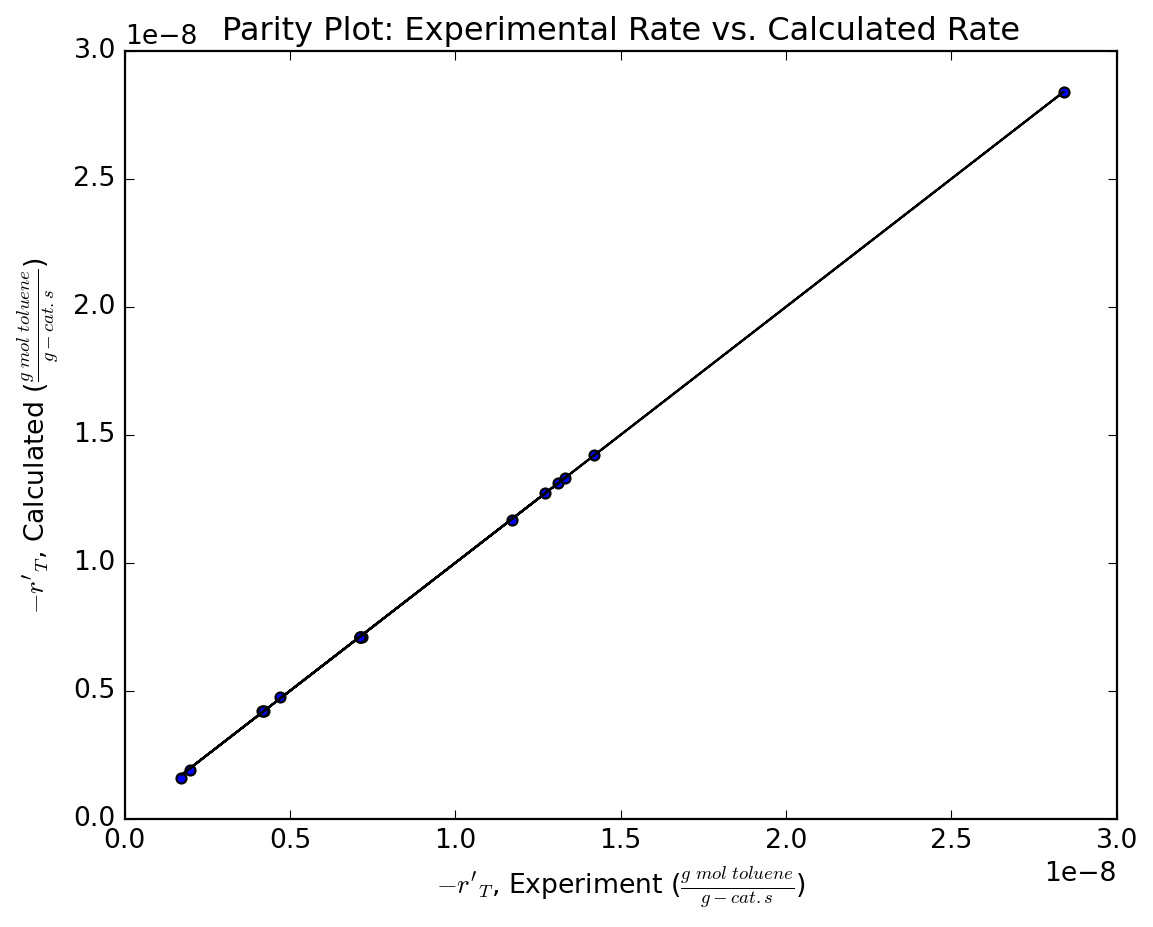

In [4]:
# Surface reaction limited
class SurfaceReactionLimited:
    def __init__(self, filename):
        self.df = pd.read_csv(filename)
        self.rate = self.df['r']
        self.x = [self.df['pT'], self.df['pH2'], self.df['pM'], self.df['pB']]

    def RateLaw(self, x, k, K_T, K_B):
        return k * (self.x[1] * self.x[0]) / (1 + K_T * self.x[0] + K_B * self.x[3])

    def getParameters(self):
        [k, K_T, K_B], params_cov = opt.curve_fit(self.RateLaw, self.x, self.rate, [144, 1.04, 1.4], maxfev=1000000)
        return [k, K_T, K_B]

    def getAccuracy(self):
        [k, K_T, K_B] = self.getParameters()
        return metrics.r2_score(self.RateLaw(self.x, k, K_T, K_B), self.rate)

    def ParityPlot(self):
        [k, K_T, K_B] = self.getParameters()
        plt.figure(facecolor="white")
        plt.title("Parity Plot: Experimental Rate vs. Calculated Rate")
        plt.scatter(self.rate, self.RateLaw(self.x, k, K_T, K_B))
        plt.plot(self.rate, self.rate, color='black')
        plt.xlabel(r"$-r'_{T}$, Experiment ($\frac{g\ mol\ toluene}{g-cat.s}$)")
        plt.ylabel(r"$-r'_{T}$, Calculated ($\frac{g\ mol\ toluene}{g-cat.s}$)")


srxn = SurfaceReactionLimited(filename)

[k, K_T, K_B] = srxn.getParameters()
display(Math(r'k: {} \\ K_T: {} \\ K_B: {}'.format(k, K_T, K_B)))

display(Math(r'R^2 = {}'.format(srxn.getAccuracy())))

srxn.ParityPlot()

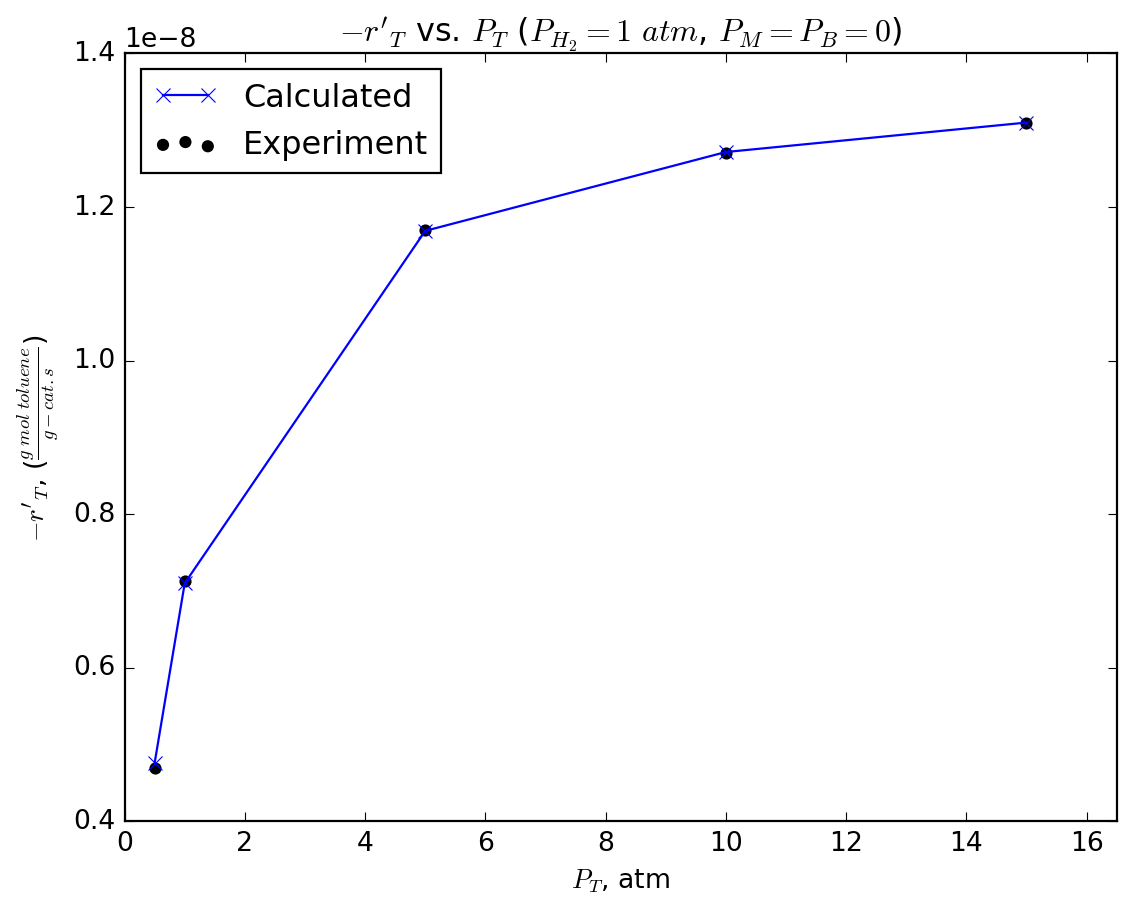

In [5]:
p_x = df['pT'][9:14]
r_y = df['r'][9:14]

x = [df['pT'], df['pH2'], df['pM'], df['pB']]

r_cal = srxn.RateLaw(x, k, K_T, K_B)

plt.figure(facecolor="white")
plt.title(r"$-r'_T$ vs. $P_T$ ($P_{H_2} = 1\ atm$, $P_M = P_B = 0$)")
plt.plot(p_x, r_cal[9:14], marker='x', label='Calculated')
plt.scatter(p_x, r_y, color='black', label='Experiment')
plt.xlabel(r"$P_T$, atm")
plt.xlim(0, 1.1 * max(p_x))
plt.ylabel(r"$-r'_{T}$, ($\frac{g\ mol\ toluene}{g-cat.s}$)")
plt.legend(loc="best")

In [6]:
strings = ['ADSORPTION limited', 'SURFACE REACTION limited', 'DESORPTION limited']
accuracy = np.array([ads.getAccuracy(), srxn.getAccuracy(), ds.getAccuracy()])
max_index = np.argmax(accuracy)
print("\nResult: Hydrodemethylation of toluene is %s." % strings[max_index])


Result: Hydrodemethylation of toluene is SURFACE REACTION limited.


---
<p style="color:#737373; font-family:futura;">Source: Fogler, H. S. (2016). Catalysis and Catalytic Reactors. In Elements of chemical reaction engineering. Boston: Prentice Hall.</p>